# Fall detection from mobile phones data

We extract a set of features from 5 second data clips and classify whether a clip corresponds to a fall or not

In [38]:
from __future__ import division

import os
import math
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

import scipy.io as sio
import scipy.stats as stats

/Users/luca/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Helper fcns

In [2]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, norm=True):

    if norm:
        totals = cmat.sum(axis=1)
        totals = totals.T
        totals = np.expand_dims(totals,axis=1)
        totals = np.tile(totals,(1,2))
        cmat_norm = cmat/totals
        print(cmat_norm)
        cm = cmat_norm

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fall','Fall'], rotation=45)
    plt.yticks(tick_marks, ['Non-Fall','Fall'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#evaluate a classifier based on a fix threshold on the maximum acceleration 
def ThresholdClass(TestData):
    """Inputs: Dataframe containing AccMax and AccMin accelerations for test data
    Outputs: dataframe of classification of test data as fall (True) or non-fall (False)"""
    TPR_thr=[]; FPR_thr=[]
    
    thrneg = np.sort(TestData[TestData['Falltype']==0]['AccMax']) #the feature value for all negatives
    thrneg = thrneg[::-1]
    N = len(thrneg)
    for fpr in np.linspace(0,1,50):
        if fpr == 1:
            thr = thrneg[-1]
        else:
            thr = thrneg[int(fpr*N)] #the threshold yielding fpr
            
        ThresPred = TestData.AccMax>thr
        Sens = len(ThresPred[(ThresPred==True) & (TestData.Falltype==1)])/len(ThresPred[TestData.Falltype==1])
        TPR_thr.append(Sens)
        FPR_thr.append(fpr)
    
    return TPR_thr, FPR_thr

In [33]:
#fit base-level and meta-level classifier - groups indexes subjects in the training data
#X_train and y_train are numpy arrays
def fit_stacking(X_train,y_train,groups): 
    
    base_classifiers = [];     meta_classifier = []
    subj = LeaveOneGroupOut()

    Xtrain_meta = np.zeros((len(y_train),len(models))) #stores the meta-level classifier features (posterior of each base-level classifier)
    ytrain_meta = np.array([]) #stores the labels to train meta-classifier
    i = 0 #counter for current classifier trained

    #CV to train base level clf and obtain train features for meta-level
    for clf,name in zip(models,model_name):

        print name
        yscoreCV = np.array([])  #stores the posterior prob of each base-level clf

        #CV to obtain posteriors from each clf (meta-features)
        for train, test in subj.split(X_train, y_train, groups):
            clf.fit(X_train[train,:],y_train[train])
            yscore = clf.predict_proba(X_train[test,:]) 
            yscore = yscore[:,1]
            yscoreCV = np.append(yscoreCV,yscore) #concatenate scores for each fold
            if i == 0:
                #store labels to train metaclassifier ()
                ytrain_meta = np.append(ytrain_meta,y_train[test])

        Xtrain_meta[:,i] = yscoreCV #store the posterior of current clf
        i +=1

        #Train base level classifiers on all training data    
        clf.fit(X_train,y_train)
        base_classifiers.append(clf)
        
    print 'base-level classifiers trained'
        
    #add extra meta-features 
    metastd = np.std(Xtrain_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtrain_meta = np.concatenate((Xtrain_meta,metastd.T),axis=1)
    
    #train meta-level classifier on posteriors (this needs another CV to optimize parameters)
    meta_scaler = preprocessing.StandardScaler().fit(Xtrain_meta)
    Xtrain_meta = meta_scaler.transform(Xtrain_meta)
    print 'training meta-classifier'
    metaclf = LogisticRegression()
    metaclf.fit(Xtrain_meta,ytrain_meta)
    ypred_meta = metaclf.predict_proba(Xtrain_meta)

    meta_classifier.append(metaclf)

    return base_classifiers, meta_classifier[0], meta_scaler

In [34]:
def predict_stacking(X_test,y_test,base_classifiers,meta_classifier,meta_scaler):
    
    Xtest_meta = np.zeros((len(y_test),len(base_classifiers))) #stores the base clf predictions for current subj
    auc_base = np.empty( (len(models),1) ) #store auc for each base classifier
    i = 0 #clf index

    #1. base-classifiers predictions
    for clf,name in zip(base_classifiers,model_name):
        Xtest_meta[:,i] = clf.predict_proba(X_test)[:,1]
        auc_base[i] = roc_auc_score(y_test, Xtest_meta[:,i])
        i+=1
    print 'best base-clf %s, auc = %.3f, worst base-clf %s, minauc = %.3f' % (model_name[np.argmax(auc_base)],
                                                                       np.max(auc_base),
                                                                       model_name[np.argmin(auc_base)],
                                                                       np.min(auc_base))

    #add extra meta features
    metastd = np.std(Xtest_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtest_meta = np.concatenate((Xtest_meta,metastd.T),axis=1)

    #2. meta-level clf predictions (final prediction)
    Xtest_meta = meta_scaler.transform(Xtest_meta)
    yscore_meta = meta_classifier.predict_proba(Xtest_meta)[:,1]
    ypred_meta = meta_classifier.predict(Xtest_meta)
    auc_meta = roc_auc_score(y_test, yscore_meta)
    print 'auc meta = %.3f\n' % (auc_meta)

    return ypred_meta, yscore_meta

In [35]:
def LOSOCV(X,y,data,groups,models,stacking=0):

    TAUC_all=[]; Tfpr_all=[]; Ttpr_all=[]; TSens_all=[]; TSpec_all=[] #store results for each subject
    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    
    subj = LeaveOneGroupOut()
    groups = data.SubjID.as_matrix() #all subjects indices
    
    #LOSO CV
    for train_index, test_index in subj.split(X, y, groups):
        Dtr = data.iloc[train_index]
        Dte = data.iloc[test_index] #the left out subject to test the classifier on
        
        #threshold method - tpr, fpr, auc
        tprT, fprT = ThresholdClass(Dte)
        tprT = np.asarray(tprT); fprT = np.asarray(fprT)
        roc_aucT = auc(fprT,tprT)
        
        #ML classifier
        if stacking == 0:
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            models.fit(Xtr,ytr)
            ypred = models.predict(Xte)
            yscore = models.predict_proba(Xte)
            yscore = yscore[:,1]
            
        else: #stacking - need a second round of CV on the train data set
            groups2 = Dtr.SubjID.as_matrix()
            Xtr = Dtr.iloc[:,4:].as_matrix(); ytr = Dtr.Falltype
            Xte = Dte.iloc[:,4:].as_matrix(); yte = Dte.Falltype
            Xtr = np.asarray(Xtr); ytr = np.asarray(ytr) #it took me 4hours to figure this line was needed!
            Xte = np.asarray(Xte); yte = np.asarray(yte) #it took me 4hours to figure this line was needed!
            base_classifiers, meta_classifier, meta_scaler = fit_stacking(Xtr,ytr,groups2) #train base and meta clf
            ypred, yscore = predict_stacking(Xte,yte,base_classifiers,meta_classifier,meta_scaler)
                
        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec
        #threshold
        ind = np.argmax(tprT-fprT)
        SensT = tprT[ind]
        SpecT = 1-fprT[ind]
        
        TAUC_all.append(roc_aucT)
        Ttpr_all.append(tprT); Tfpr_all=fprT;
        TSens_all.append(SensT); TSpec_all.append(SpecT)
        
        #ML classifier
        ind = np.argmax(tpr-fpr)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)
        
        print('AUC_T = %.4f, Sens_T = %.4f, Spec_T = %.4f'%(roc_aucT,SensT,SpecT)) #threshold
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f\n'%(roc_auc,Sens,Spec)) #random forest
        

    #summary results
    print(('mean AUC_T = %.3f (+/- %0.3f)')%(np.mean(TAUC_all),2*np.std(TAUC_all)))
    print(('mean Sens_T = %.3f (+/- %0.3f)')%(np.mean(TSens_all),2*np.std(TSens_all)))
    print(('mean Spec_T = %.3f (+/- %0.3f)')%(np.mean(TSpec_all),2*np.std(TSpec_all)))
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))


    results_T = {'AUC':TAUC_all, 'TPR':Ttpr_all, 'FPR':Tfpr_all, 'Sens':TSens_all, 'Spec':TSpec_all}
    results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all}
    return results_T, results

In [174]:
#Train on one group (e.g. healthy) and test on the other (e.g amputee)
#Xtr,ytr,X,y are numpy arrays (this is redundant and will be changed later)
#data2 is the dataframe of the test group
#clf is the classifier (or the base models for stacking) to train

def EvaluateBySubject(Xtr,ytr,groups1,X,y,groups2,data2,clf,stacking=0):

    TAUC_all=[]; Tfpr_all=[]; Ttpr_all=[]; TSens_all=[]; TSpec_all=[] #store results for each subject
    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    TOpt_all = []; T90_all = []

    #Train on the population in Xtr
    if not stacking:
        clf.fit(Xtr,ytr)
    else: 
        base_classifiers, meta_classifier, meta_scaler = fit_stacking(Xtr,ytr,groups1)
        
        
    #test on the other population by subject
    subj = LeaveOneGroupOut()
    for train_index, test_index in subj.split(X, y, groups2):
        
        #threshold classifier
        Dte = data2.iloc[test_index]
        tprT, fprT = ThresholdClass(Dte)
        tprT = np.asarray(tprT); fprT = np.asarray(fprT)
        roc_aucT = auc(fprT,tprT)
        
        Xte = X[test_index]
        yte = y[test_index]

        #predict
        if not stacking:
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
        else:
            ypred, yscore = predict_stacking(Xte,yte,base_classifiers,meta_classifier,meta_scaler)
            

        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        t_all = [] #for obtaining thresholds
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            t_all.append(t)
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec:
        #threshold
        ind = np.argmax(tprT-fprT)
        SensT = tprT[ind]
        SpecT = 1-fprT[ind]
        
        TAUC_all.append(roc_aucT)
        Ttpr_all.append(tprT); Tfpr_all=fprT;
        TSens_all.append(SensT); TSpec_all.append(SpecT)
        
        #ML classifier
        ind = np.argmax(tpr-fpr,axis=0)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        ## Thresholds
        TOpt_all.append(t_all[ind])
        T90_all.append(t_all[np.argmin(abs(tpr-.90))])
        
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)
        
        print('AUC_T = %.4f, Sens_T = %.4f, Spec_T = %.4f'%(roc_aucT,SensT,SpecT)) #threshold
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f\n'%(roc_auc,Sens,Spec)) #ML classifier
        

#     TOpt = np.mean(TOpt_all)
#     T90 = np.mean(T90_all)
        
    #summary results
    print(('mean AUC_T = %.3f (+/- %0.3f)')%(np.mean(TAUC_all),2*np.std(TAUC_all)))
    print(('mean Sens_T = %.3f (+/- %0.3f)')%(np.mean(TSens_all),2*np.std(TSens_all)))
    print(('mean Spec_T = %.3f (+/- %0.3f)')%(np.mean(TSpec_all),2*np.std(TSpec_all)))
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))


    results_T = {'AUC':TAUC_all, 'TPR':Ttpr_all, 'FPR':Tfpr_all, 'Sens':TSens_all, 'Spec':TSpec_all}
    results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all, 'TOpt':TOpt_all,
               'T90':T90_all}
    return results_T, results

In [5]:
def HomeDataEval(Dtr,D,Threshold):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]; t_all=[]
    TTPR_all, TSpec_all = [], []
    FPCount_all, TFPCount_all = [], []
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    #train and test data as numpy arrays
    Xtr = Dtr.iloc[:,4:].as_matrix()
    ytr = Dtr.Falltype.as_matrix()
    X = D.iloc[:,4:].as_matrix()
    y = D.Falltype.as_matrix()

    #select train features and train on the population in Xtr
    Xtr = Xtr[:,indmax]
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False,class_weight=None)    
    forest.fit(Xtr,ytr)
    
    #split by subject for testing on X,y
    groups = D.SubjID.as_matrix()
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    
    for train_index, test_index in subj.split(X, y, groups):
        
        Dte = D.iloc[test_index]
            
        _, SpecT = ThresholdClass(Dte)
        TSpec_all.append(SpecT)
        
        Xte = X[test_index]
        yte = y[test_index]
        
        #selct test features
        Xte = Xte[:,indmax]

        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]
        
        #compute Sens and Spec
        Sens = sum((yscore>Threshold) & (yte==1)) / sum(yte==1); Spec = 1-sum((yscore>Threshold) & (yte==0)) / sum(yte==0)
        
        Spec_all.append(Spec)

    return Spec_all, TSpec_all

In [6]:
current_palette = sns.color_palette()

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '--'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    return ax

# Load the data 
We remove activities whose maximum acceleration is below 2g. This makes the problem more challenging, as only activities which involve high acceleration movements, which can be confounded with falls, are included.

In [11]:
#Load and normalize data from healthy and amputees
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Healthy.loc[Healthy['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2

#binarize labels - WARNING! It modifies the labels y in the original dataframe (passed by reference)
XH = Healthy.iloc[:,4:].as_matrix()
yH = Healthy.Falltype.as_matrix()
yH[yH < 9] = 1
yH[yH == 9] = 0
groupsH = Healthy.SubjID.as_matrix() #for CV

Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype', 950:'AccMax',951:'AccMin'})
Amp = Amp[Amp.SubjID != 2] #drop subj 2 (no activities)
Amp.loc[Amp['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2

#binarize labels
XA = Amp.iloc[:,4:].as_matrix()
yA = Amp.Falltype.as_matrix()
yA[yA < 9] = 1
yA[yA == 9] = 0
groupsA = Amp.SubjID.as_matrix()

#standardize data
# scaler = preprocessing.StandardScaler().fit(XH) #define scaler
# XH = scaler.transform(XH)
# XA = scaler.transform(XA)

#Tot Features - #602 gyro features + 602 accelerometer
#use magnitude features only and standardize values in the data frame
indmax = np.linspace(336,355,20)
indmax = np.hstack([indmax,np.linspace(336,355,20)+602])
indmax = indmax.astype(int)
XH = XH[:,indmax]; XA = XA[:,indmax]
#standardize data
scaler = preprocessing.StandardScaler().fit(XH) #define scaler on Healthy data
XH = scaler.transform(XH)
XA = scaler.transform(XA)
Healthy = pd.concat([Healthy.iloc[:,0:4],Healthy.iloc[:,indmax+4]],axis=1)
Amp = pd.concat([Amp.iloc[:,0:4],Amp.iloc[:,indmax+4]],axis=1)
#Standardize values in dataframes
Healthy.iloc[:,4:] = XH 
Amp.iloc[:,4:] = XA

Need to name feature cols (see paper for details)

In [12]:
Healthy.head()

,SubjID,Loc,Subjtype,Falltype,340,341,342,343,344,345,...,952,953,954,955,956,957,958,959,960,961
0,1,1,1,1,-0.642517,-0.567638,-0.434362,0.178106,-0.133796,-0.028496,...,-0.045042,0.076516,0.143173,-1.413770,-1.014424,-0.947475,-1.018511,-0.235111,0.343408,0.468849
1,1,1,1,1,-0.575281,-0.597779,-0.205036,0.708730,0.383599,-0.054943,...,-0.019652,0.013868,0.062215,-1.620809,-0.828200,-1.004717,-1.262990,-0.223550,0.696958,1.194595
2,1,1,1,1,-0.582354,-0.598346,-0.291232,1.140982,0.882159,-0.837750,...,-0.039026,0.076132,-0.432138,-1.522830,-0.865960,-1.010060,-1.246970,0.025528,0.370716,-0.495523
3,1,1,1,1,-0.777615,-0.599589,-0.798656,0.051861,-0.142354,-1.240404,...,-0.002936,0.036600,-0.129833,-1.468343,-1.041726,-1.017619,-1.261142,-0.625362,-0.053359,-0.281033
4,1,1,1,1,-0.759997,-0.579352,-0.715428,0.555447,0.248552,-1.276331,...,0.016665,0.035355,-0.057017,-1.343086,-1.260929,-0.896024,-0.968770,-0.525051,-0.288529,0.155861


In [20]:
print(len(Healthy))
print(len(Amp))

6652
1844


In [21]:
print(('N subjects Healthy: %s'%(len(Healthy.SubjID.unique()))))
print(('N subjects Amp: %s'%(len(Amp.SubjID.unique()))))
print(Healthy.Subjtype.unique())
print(Amp.Subjtype.unique())

N subjects Healthy: 10
N subjects Amp: 6
[1]
[0]


In [22]:
#Subjects with indoor and outdoor falls
print(np.sort(Healthy[Healthy.Subjtype == 1].SubjID.unique()))
print(np.sort(Healthy[Healthy.Subjtype == 2].SubjID.unique()))

[ 1  2  3  4  5  6  7  8  9 10]
[]


In [23]:
#Healthy
print(('Nfalls = %s')%(len(Healthy[Healthy.Falltype==1])))
print(('Nactivities = %s')%(len(Healthy[Healthy.Falltype==0])))

Nfalls = 6337
Nactivities = 315


In [24]:
#Amp
print(('Nfalls = %s')%(len(Amp[Amp.Falltype==1])))
print(('Nactivities = %s')%(len(Amp[Amp.Falltype==0])))

Nfalls = 1537
Nactivities = 307


In [25]:
# sns.distplot(Healthy.loc[Healthy['Falltype']==1,'AccMax'])

## Distribution of acceleration Magnitude in the original data set (includes clip with acc < 2g)

In [26]:
MaxAcc = pd.read_csv('./Data/AccMax.csv',header=None)
MaxAcc = MaxAcc.rename(index=int,columns={0:'SubjType',1:'FallType',2:'AccMax'})

In [27]:
MaxAcc.head()

,SubjType,FallType,AccMax
0,1,1,3.2416
1,1,1,3.2021
2,1,1,3.2232
3,1,1,3.1034
4,1,1,3.1056


In [28]:
len(MaxAcc)

12090

In [29]:
MaxAcc.SubjType.unique()

array([1, 0])

In [30]:
# (MaxAcc['SubjType']==1)
print MaxAcc.FallType.unique()

[1 0]


In [31]:
MaxAcc.loc[MaxAcc.AccMax > 5] = 5 #saturate the max acceleration

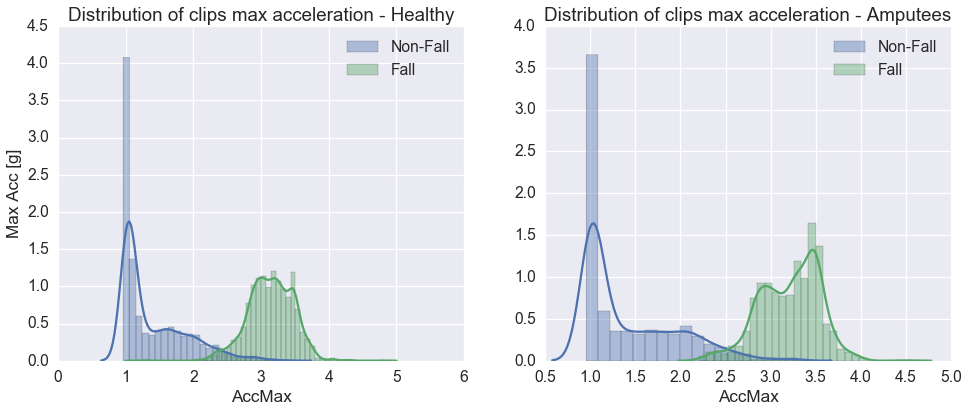

In [32]:
sns.set_context('talk',font_scale=1.2)
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
sns.distplot(MaxAcc[(MaxAcc['FallType']==0) & (MaxAcc['SubjType']==0)]['AccMax'],ax=ax1,label='Non-Fall')
sns.distplot(MaxAcc[(MaxAcc['FallType']==1) & (MaxAcc['SubjType']==0)]['AccMax'],ax=ax1,label='Fall')
plt.legend(); 
ax1.set_title('Distribution of clips max acceleration - Healthy'); ax1.set_ylabel('Max Acc [g]')
ax2 = fig.add_subplot(122)
sns.distplot(MaxAcc[(MaxAcc['FallType']==0) & (MaxAcc['SubjType']==1)]['AccMax'],ax=ax2,label='Non-Fall')
sns.distplot(MaxAcc[(MaxAcc['FallType']==1) & (MaxAcc['SubjType']==1)]['AccMax'],ax=ax2,label='Fall')
ax2.set_title('Distribution of clips max acceleration - Amputees'); ax1.set_ylabel('Max Acc [g]')
plt.legend(); 

Not surprisingly the majority of daily activities (Non-Fall) show accelerations in the range below 2g.

# Feature selection on healthy data using Random Forest - can skip if using magnitude features

In [27]:
Xtr = Healthy.iloc[:,4:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
yH[yH < 9] = 1
yH[yH == 9] = 0
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [28]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[  2.92907709e-04   1.88250329e-04   4.01622778e-04 ...,   1.63494575e-05
   1.27462874e-04   1.18851540e-04]
[ 0.00205035  0.00096476  0.00172766 ...,  0.00011445  0.00067165
  0.00058328]


In [29]:
importance_norm = importance/np.max(importance)

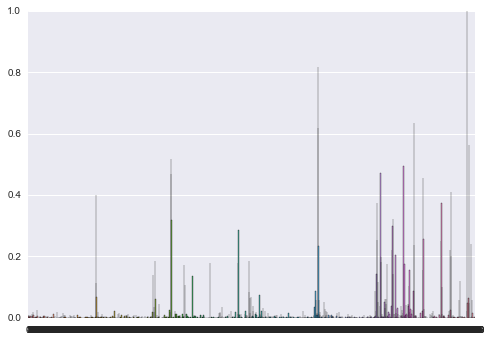

In [30]:
#using Seaborn
sns.set_context("notebook")
ax = sns.barplot(x=indices,y=importance_norm[indices])
plt.figure(figsize=(8,6))

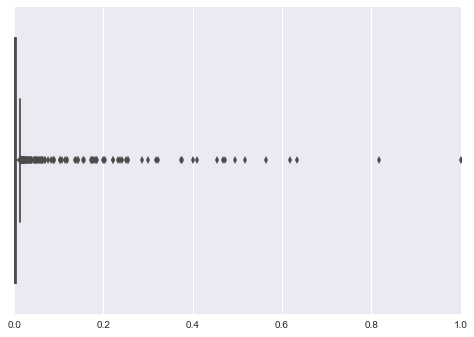

In [31]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [32]:
qc = np.percentile(importance_norm,[75])
print(1.5*qc)

[ 0.00736617]


In [33]:
# indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
print(len(indmax))
print(indmax)

#use features subset (optimized on random forest)
XH = XH[:,indmax]; XA = XA[:,indmax]

49
[ 183  184  338  344  386  387  388  423  424  445  492  569  570  599  785
  786  787  944  945  946  948  955  956  957  972  986  988  989  990  996
 1018 1020 1033 1034 1046 1047 1070 1071 1072 1120 1121 1122 1144 1146 1147
 1171 1190 1195 1200]


# LOSO CV on Healthy
We perform Leave One Subject Out (LOSO) Cross validation to test the performance of our model

In [187]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='linear',C=1,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=0.6,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']

In [188]:
results_T, results = LOSOCV(XH,yH,Healthy,groupsH,models,stacking=1)

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 1.000, worst base-clf Gradient Boosting, minauc = 0.998
auc meta = 1.000

AUC_T = 0.9937, Sens_T = 0.9122, Spec_T = 1.0000
AUC = 0.9999, Sens = 0.9970, Spec = 1.0000

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.995, worst base-clf Gradient Boosting, minauc = 0.966
auc meta = 0.992

AUC_T = 0.9925, Sens_T = 0.9658, Spec_T = 1.0000
AUC = 0.9918, Sens = 0.9494, Spec = 1.0000

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf Random Forest, auc = 0.993, worst base-clf SVM, minauc = 0.978
auc meta = 0.996

AUC_T = 0.9747, Sens_T = 0.9622, Spec_T = 0.8980
AUC = 0.9955, Sens = 0.9622, Spec = 0.9700

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf Random Forest, auc = 1.000, wo

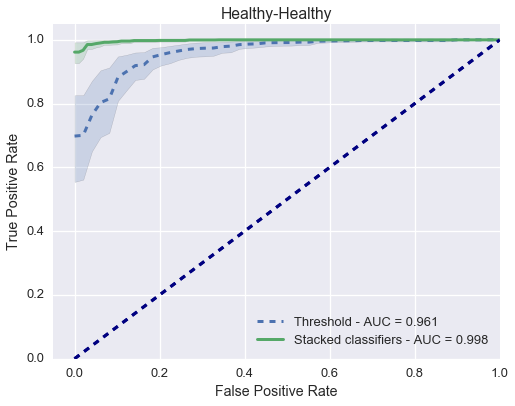

In [189]:
plt.figure(figsize=(8,6))
AX = plot_roc(results_T['TPR'],results_T['FPR'],np.mean(results_T['AUC']),plotname='Threshold')
plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=AX,plotname='Stacked classifiers',col=current_palette[1])
AX.set_title('Healthy-Healthy')

Compared to a simple threshold approach (i.e. a fall is detected if the max accleration in a clip exceeds a fixed threshold), the ML model performs significantly better, allowing to reduce the False positive rate significantly 

# LOSO CV on Amputees

**Note: SubjID 2 does not have activities**

In [50]:
np.unique(groupsA)

array([1, 3, 4, 5, 6, 7])

In [51]:
resultsAA_T, resultsAA = LOSOCV(XA,yA,Amp,groupsA,models,stacking=1)

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.996, worst base-clf Gradient Boosting, minauc = 0.993
auc meta = 0.997

AUC_T = 0.9494, Sens_T = 0.8834, Spec_T = 0.9184
AUC = 0.9967, Sens = 0.9955, Spec = 0.9400

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf Random Forest, auc = 0.997, worst base-clf SVM, minauc = 0.994
auc meta = 0.995

AUC_T = 0.9994, Sens_T = 1.0000, Spec_T = 0.9796
AUC = 0.9948, Sens = 1.0000, Spec = 0.9300

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf XGB, auc = 1.000, worst base-clf SVM, minauc = 0.997
auc meta = 1.000

AUC_T = 0.9917, Sens_T = 0.9231, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf Gradient Boosting, auc = 0.992, worst base-c

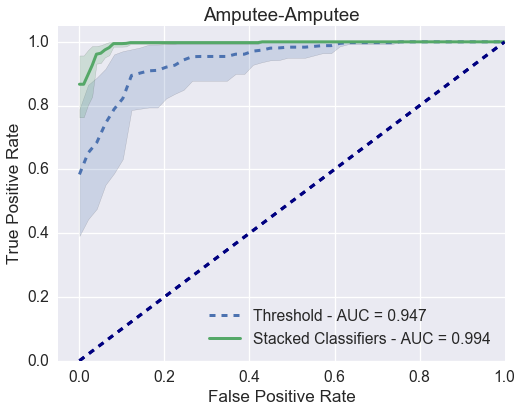

In [52]:
plt.figure(figsize=(8,6))
AX = plot_roc(resultsAA_T['TPR'],resultsAA_T['FPR'],np.mean(resultsAA_T['AUC']),plotname='Threshold')
plot_roc(resultsAA['TPR'],resultsAA['FPR'],np.mean(resultsAA['AUC']),ax=AX,plotname='Stacked Classifiers',col=current_palette[1])
AX.set_title('Amputee-Amputee')

# Healthy to Amputee w/ folds 

In [57]:
resultsHA_T, resultsHA = EvaluateBySubject(XH,yH,groupsH,XA,yA,groupsA,Amp,clf=models,stacking=1)

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf Gradient Boosting, auc = 0.999, worst base-clf SVM, minauc = 0.996
auc meta = 0.998

AUC_T = 0.9494, Sens_T = 0.8834, Spec_T = 0.9184
AUC = 0.9979, Sens = 0.9865, Spec = 0.9700

best base-clf SVM, auc = 0.999, worst base-clf Random Forest, minauc = 0.998
auc meta = 0.998

AUC_T = 0.9994, Sens_T = 1.0000, Spec_T = 0.9796
AUC = 0.9985, Sens = 0.9942, Spec = 0.9800

best base-clf Random Forest, auc = 1.000, worst base-clf Random Forest, minauc = 1.000
auc meta = 1.000

AUC_T = 0.9917, Sens_T = 0.9231, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

best base-clf Gradient Boosting, auc = 0.993, worst base-clf Random Forest, minauc = 0.988
auc meta = 0.993

AUC_T = 0.9273, Sens_T = 0.8651, Spec_T = 0.8776
AUC = 0.9933, Sens = 0.9953, Spec = 0.9200

best base-clf SVM, auc = 0.985, worst base-clf XGB, minauc = 0.973
auc meta = 0.989

AUC_T = 0.8246, Sens_T = 0.7714, Spec_T

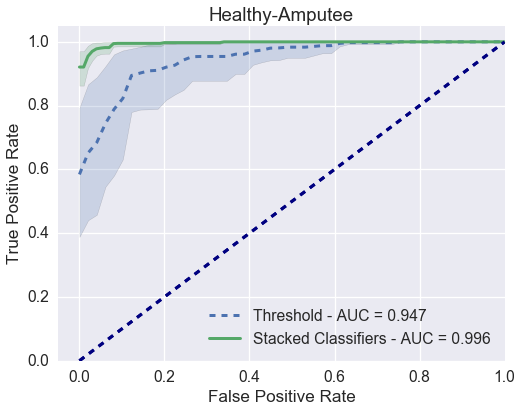

In [58]:
plt.figure(figsize=(8,6))
AX = plot_roc(resultsHA_T['TPR'],resultsHA_T['FPR'],np.mean(resultsHA_T['AUC']),plotname='Threshold')
plot_roc(resultsHA['TPR'],resultsHA['FPR'],np.mean(resultsHA['AUC']),ax=AX,plotname='Stacked Classifiers',col=current_palette[1])
AX.set_title('Healthy-Amputee')

In all 3 cases, the machine learning approach yields significantly better results than the threshold method

In [1208]:
[t_value, p_value] = stats.ttest_rel(AUC_all_HA,AUC_all_AA)
print('HA vs. AA %0.3f'%(p_value))

[t_value, p_value] = stats.ttest_ind(AUC_all_HH,AUC_all_HA)
print('HH vs. HA %0.3f'%(p_value))

HA vs. AA 0.382
HH vs. HA 0.462


# Make summary figure with 3 subplots

In [1211]:
fig = ax1.get_figure()
fig.savefig('./Figs/Fig2.jpg')

In [1212]:
ax.get_legend_handles_labels()

([], [])

# Location Analysis

## Train on all locs (Healthy) and test on each location (Waist, Pocket and Hand) for amputees

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf Random Forest, auc = 1.000, worst base-clf Random Forest, minauc = 1.000
auc meta = 1.000

AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

best base-clf Random Forest, auc = 1.000, worst base-clf Random Forest, minauc = 1.000
auc meta = 1.000

AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

best base-clf Random Forest, auc = 1.000, worst base-clf Random Forest, minauc = 1.000
auc meta = 1.000

AUC_T = 1.0000, Sens_T = 1.0000, Spec_T = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

best base-clf Gradient Boosting, auc = 0.980, worst base-clf SVM, minauc = 0.965
auc meta = 0.977

AUC_T = 0.8957, Sens_T = 0.8795, Spec_T = 0.8571
AUC = 0.9772, Sens = 1.0000, Spec = 0.8900

best base-clf Gradient Boosting, auc = 0.993, worst base-clf Random Forest, minauc = 0.982
auc meta = 0.991

AUC_T = 0

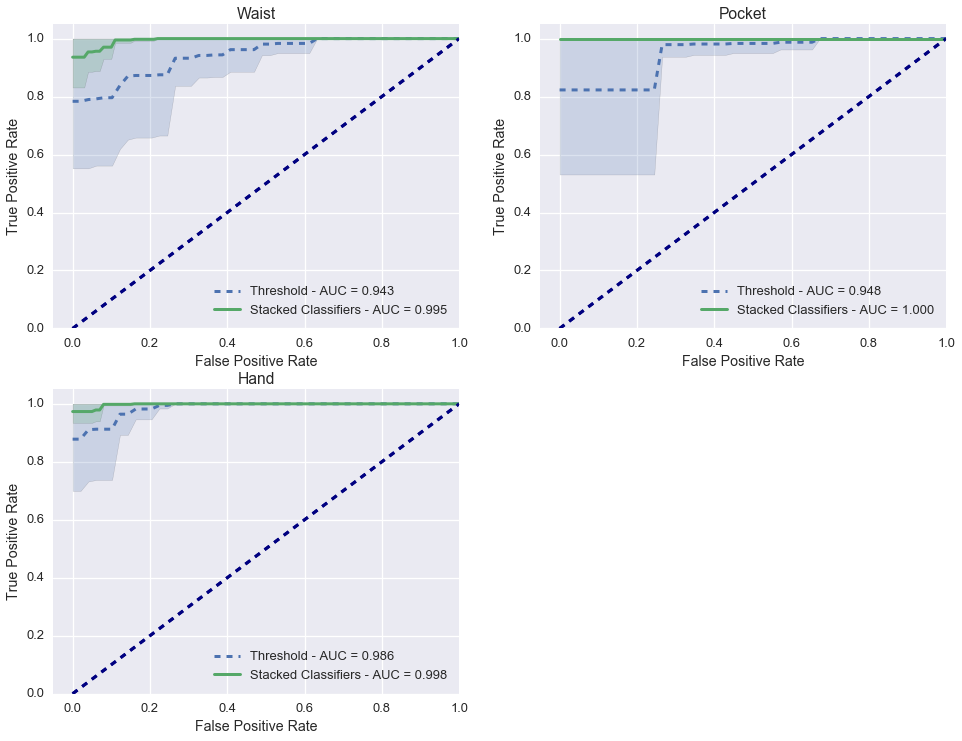

In [103]:
sns.set_context('talk')
locs = [1,2,3]
fig = plt.figure(figsize=(16,12))
ax1=None

#remove subjects with no falls for some locations
Amp = Amp[(Amp.SubjID!=1)|(Amp.Loc!=2)]
Amp = Amp[(Amp.SubjID!=6)|((Amp.Loc!=2)&(Amp.Loc!=3))]

locAUC=[]; locAUC_T=[]

for l,name in zip(locs,['Waist','Pocket','Hand']):
    
    #filter amputees data (test data)
    Ampdata = Amp[Amp.Loc==l]
    XAloc = Ampdata.iloc[:,4:].as_matrix(); yAloc = Ampdata.Falltype.as_matrix() #this has to be moved inside EvaluateBySubject
    XAloc = np.asarray(XAloc); yAloc = np.asarray(yAloc)
    groupsAloc = Ampdata.SubjID.as_matrix()
    
    results_T, results = EvaluateBySubject(XH,yH,groupsH,XAloc,yAloc,groupsAloc,Ampdata,clf=models,stacking=1)
        
    AX = fig.add_subplot(2,2,l) #uncomment this line to generate subplots
    plot_roc(results_T['TPR'],results_T['FPR'],np.mean(results_T['AUC']),plotname='Threshold',ax=AX)
    plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=AX,plotname='Stacked Classifiers',col=current_palette[1])
    AX.set_title('%s'%(name))
    
    locAUC.append(results)
    locAUC_T.append(results_T)
    
# ax1.set_title('Results by location')
# ax1.legend(loc=4,fontsize = 18)

In [109]:
[t_value, p_value] = stats.ttest_ind(locAUC[0]['AUC'],locAUC[1]['AUC'],equal_var=False)
print('Waist vs. Pocket %0.3f'%(p_value))

[t_value, p_value] = stats.ttest_ind(locAUC[0]['AUC'],locAUC[2]['AUC'],equal_var=False)
print('Waist vs. Hand %0.3f'%(p_value))

[t_value, p_value] = stats.ttest_ind(locAUC[1]['AUC'],locAUC[2]['AUC'],equal_var=False)
print('Pocket vs. Hand %0.3f'%(p_value))

Waist vs. Pocket 0.221
Waist vs. Hand 0.448
Pocket vs. Hand 0.228


In [1215]:
fig = ax1.get_figure()
fig.savefig('./Figs/Fig3.jpg')
fig.savefig('./Figs/Fig3.tif')

In [111]:
len(Amp)

1814

# Home data analysis
Train on healthy and test on 3 amputees who carried the phone for 2 or more days during their daily routine. Activites data is recorded over days subjects carried the phone and filtered as above (only clips with MaxAcc > 2g are included). Falls data is the same as used in the former analysis.

**Note: Here I am reloading the dataframe for Amputees. Need to check how to copy recursively (i.e. without making a reference to the object. Need to take care of this later to optimize the code**

In [121]:
Homedata.head()

,SubjID,Loc,Subjtype,Falltype,340,341,342,343,344,345,...,952,953,954,955,956,957,958,959,960,961
0,1,1,1,0,-0.854016,0.007196,-1.234276,-1.511799,-1.016811,-1.435755,...,-0.095234,0.132802,-0.971427,-0.946832,-0.390793,0.222872,1.006398,-1.201161,-1.444096,-2.215053
1,1,1,1,0,-0.888540,-0.034469,-1.251908,-1.148591,-0.709017,-1.558956,...,-0.097304,0.125786,-0.991566,-0.892068,-0.361599,0.307476,0.642578,-1.351061,-1.426863,-2.372065
2,1,1,1,0,-0.842048,0.017217,-1.236971,-1.815683,-1.152247,-1.613327,...,-0.099615,0.124936,-1.054019,-0.962330,-0.474511,0.234820,0.580681,-1.309860,-1.452779,-2.247495
3,1,1,1,0,-0.936153,-0.132623,-1.264194,-1.244337,-0.844389,-1.745676,...,-0.103054,0.119781,-1.183737,-0.982885,-0.246453,-0.055665,-0.013175,-1.318361,-1.471935,-2.175184
4,1,1,1,0,-0.690950,0.245004,-1.145963,-1.534200,-1.011409,-1.448702,...,-0.091191,0.111387,-1.187839,-0.998383,-0.544618,-0.032184,0.275771,-1.264181,-1.455430,-2.110300


In [122]:
len(Homedata)

2467

In [165]:
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Amp = Amp[Amp.SubjID != 2] #drop subj 2 (no activities)
Amp.loc[Amp['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
Amp.loc[Amp.Falltype<9,'Falltype'] = 1 #binarize labels
Amp.loc[Amp.Falltype==9,'Falltype'] = 0
Amp = pd.concat([Amp.iloc[:,0:4],Amp.iloc[:,indmax+4]],axis=1) #selected features
XA = Amp.iloc[:,4:].as_matrix()
yA = Amp.Falltype.as_matrix()

Homedata = pd.read_csv('./Data/HomeData.csv',header=None)
Homedata = Homedata.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Homedata.loc[Homedata['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
Homedata.Falltype = 0
Homedata = pd.concat([Homedata.iloc[:,0:4],Homedata.iloc[:,indmax+4]],axis=1) #selected features
XAh = Homedata.iloc[:,4:].as_matrix() 
yAh = Homedata.Falltype.as_matrix()
    
#standardize data (this could be achieved with .apply method)
XA = scaler.transform(XA)
XAh = scaler.transform(XAh);
Amp.iloc[:,4:] = XA 
Homedata.iloc[:,4:] = XAh

homesubj = Homedata.SubjID.unique() #the subjects with home data
print homesubj
for s in homesubj:
    Homedata = pd.concat([Amp[(Amp.SubjID==s) & (Amp.Falltype==1)],Homedata],axis=0)
    
#the home data to test on
groupsHome = Homedata.SubjID
XAh = Homedata.iloc[:,4:].as_matrix()
yAh = Homedata.Falltype.as_matrix()

[1 6 7]


In [175]:
resultsHome_T, resultsHome = EvaluateBySubject(XH,yH,groupsH,XAh,yAh,groupsHome,Homedata,clf=models,stacking=1)


Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
training meta-classifier
best base-clf Random Forest, auc = 0.993, worst base-clf XGB, minauc = 0.987
auc meta = 0.992

AUC_T = 0.9627, Sens_T = 0.9910, Spec_T = 0.8367
AUC = 0.9930, Sens = 0.9865, Spec = 0.9200

best base-clf SVM, auc = 0.992, worst base-clf Random Forest, minauc = 0.978
auc meta = 0.991

AUC_T = 0.7434, Sens_T = 0.6286, Spec_T = 0.8367
AUC = 0.9911, Sens = 0.9429, Spec = 0.9700

best base-clf XGB, auc = 0.997, worst base-clf Random Forest, minauc = 0.988
auc meta = 0.994

AUC_T = 0.9713, Sens_T = 0.9759, Spec_T = 0.8776
AUC = 0.9940, Sens = 0.9940, Spec = 0.9500

mean AUC_T = 0.892 (+/- 0.211)
mean Sens_T = 0.865 (+/- 0.335)
mean Spec_T = 0.850 (+/- 0.038)
mean AUC = 0.993 (+/- 0.002)
mean Sens = 0.974 (+/- 0.045)
mean Spec = 0.947 (+/- 0.041)


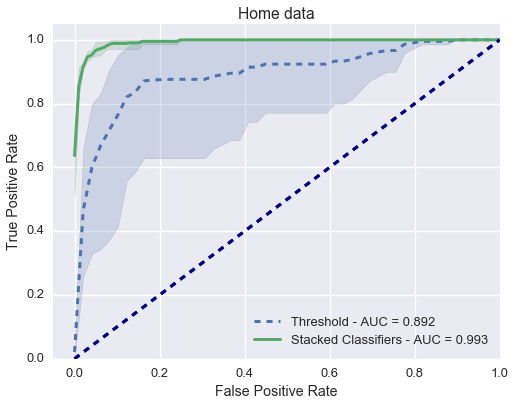

In [176]:
plt.figure(figsize=(8,6))
AX = plot_roc(resultsHome_T['TPR'],resultsHome_T['FPR'],np.mean(resultsHome_T['AUC']),plotname='Threshold')
plot_roc(resultsHome['TPR'],resultsHome['FPR'],np.mean(resultsHome['AUC']),ax=AX,plotname='Stacked Classifiers',col=current_palette[1])
AX.set_title('Home data')

In [184]:
resultsHome.keys()

['AUC', 'TOpt', 'TPR', 'FPR', 'Sens', 'T90', 'Spec']

In [197]:
resultsHome['Spec']

[0.92000000000000004, 0.96999999999999997, 0.94999999999999996]

In [1224]:
fig = ax2.get_figure()
fig.savefig('./Figs/Fig4.jpg')
fig.savefig('./Figs/Fig4.tif')

# Stacking  - Base classifiers Hyperparameter optimization
1) Optimize 4 different classifiers (using LOSO CV)

2) Use stacking for final prediction

In [171]:
#try SVM
auc_all = []
clf = SVC(kernel='linear',cache_size=800,probability=True,random_state=3)
# clf = GradientBoostingClassifier(n_estimators=100,subsample=0.8)
for train_index, test_index in subj.split(X, y, groups):
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    Xtr, Xte = Xtr[:,indmax], Xte[:,indmax] #selct features

    #normalize data
    scaler = preprocessing.StandardScaler().fit(Xtr)
    scaler.transform(Xte)

    #fit svm and compute ROC for each subject
    clf.fit(Xtr,ytr)
    ypred = clf.predict(Xte)
    yscore = clf.predict_proba(Xte)[:,1]
    fpr,tpr,thr = roc_curve(yte,yscore,pos_label=1)
    roc_auc = auc(fpr, tpr)
    auc_all.append(roc_auc)
    print 'AUC = %.3f'%roc_auc

print 'mean AUC = %.3f +/- %.3f'%(np.mean(auc_all),2*np.std(auc_all))

AUC = 0.979
AUC = 0.992
AUC = 1.000
AUC = 0.983
AUC = 0.992
AUC = 0.999
mean AUC = 0.991 +/- 0.015


In [1203]:
AUC_all_AA, fpr_all_AA, tpr_all_AA, Sens_all_AA, Spec_all_AA, TTPR_allAA, TFPR_allAA = LOSOCV(X,y,Amp)

AUC = 0.9888, Sens = 1.0000, Spec = 0.9200
AUC = 0.9969, Sens = 1.0000, Spec = 0.9600
AUC = 0.9999, Sens = 0.9943, Spec = 1.0000
AUC = 0.9837, Sens = 0.9442, Spec = 0.9400
AUC = 0.9829, Sens = 0.9714, Spec = 0.9500
AUC = 0.9980, Sens = 0.9819, Spec = 0.9800
mean AUC = 0.992 (+/- 0.014)
mean Sens = 0.982 (+/- 0.040)
mean Spec = 0.958 (+/- 0.052)


In [13]:
#Load and normalize data from healthy and amputees
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Healthy.loc[Healthy['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
#binarize labels
XH = Healthy.iloc[:,4:].as_matrix()
yH = Healthy.Falltype.as_matrix()
yH[yH < 9] = 1
yH[yH == 9] = 0
scaler = preprocessing.StandardScaler().fit(XH) #define scaler
XH = scaler.transform(XH)
groupsH = Healthy.SubjID.as_matrix() #for CV

Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype', 950:'AccMax',951:'AccMin'})
Amp = Amp[Amp.SubjID != 2] #drop subj 2
Amp.loc[Amp['AccMax']>2500,'AccMax'] = 2500 #saturate max acceleration to 5g (in m/s^2)^2
#binarize labels
XA = Amp.iloc[:,4:].as_matrix()
yA = Amp.Falltype.as_matrix()
yA[yA < 9] = 1
yA[yA == 9] = 0
XA = scaler.transform(XA)
groupsA = Amp.SubjID.as_matrix()

#Tot Features - #602 gyro features + 602 accelerometer
#use features subset (optimized on random forest)
# XH = XH[:,indmax]; XA = XA[:,indmax]

#use magnitude features only
indmax = np.linspace(336,355,20)
indmax = np.hstack([indmax,np.linspace(336,355,20)+602])
indmax = indmax.astype(int)
XH = XH[:,indmax]; XA = XA[:,indmax]

In [14]:
#try SVM
auc_all = []
clf = SVC(kernel='linear',cache_size=800,probability=True,random_state=3,C=1)
X = XH; y = yH; groups = groupsH
subj = LeaveOneGroupOut()

for train_index, test_index in subj.split(X, y, groupsH):
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
#     Xtr, Xte = Xtr[:,indmax], Xte[:,indmax] #selct features

    #fit svm and compute ROC for each subject
    clf.fit(Xtr,ytr)
    ypred = clf.predict(Xte)
    yscore = clf.predict_proba(Xte)[:,1]
    fpr,tpr,thr = roc_curve(yte,yscore,pos_label=1)
#     roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(yte,yscore)
    auc_all.append(roc_auc)
    print 'AUC = %.3f'%roc_auc

print 'mean AUC = %.3f +/- %.3f'%(np.mean(auc_all),2*np.std(auc_all))

AUC = 1.000
AUC = 0.995
AUC = 0.984
AUC = 1.000
AUC = 1.000
AUC = 0.998
AUC = 1.000
AUC = 1.000
AUC = 0.998
AUC = 0.998
mean AUC = 0.997 +/- 0.009


In [15]:
#test SVM on Amputees
#try SVM
auc_all = []
X = XA; y = yA; groups = groupsH
subj = LeaveOneGroupOut()

for train_index, test_index in subj.split(X, y, groupsA):
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]

    #compute ROC for each subject
    ypred = clf.predict(Xte)
    yscore = clf.predict_proba(Xte)[:,1]
    fpr,tpr,thr = roc_curve(yte,yscore,pos_label=1)
    roc_auc = roc_auc_score(yte,yscore)
    auc_all.append(roc_auc)
    print 'AUC = %.3f'%roc_auc

print 'mean AUC = %.3f +/- %.3f'%(np.mean(auc_all),2*np.std(auc_all))

AUC = 0.999
AUC = 1.000
AUC = 1.000
AUC = 0.993
AUC = 0.989
AUC = 1.000
mean AUC = 0.997 +/- 0.009


In [16]:
models = [[ RandomForestClassifier(random_state=2), {'n_estimators': [10,50,100]}, "Random Forest"]]

models.append([GradientBoostingClassifier(random_state=2), {'n_estimators':[10,50,100], 'max_depth':[2,4]}, "GradientBoost" ])

models.append([SVC(kernel='linear',cache_size=800,random_state=3,probability=True), {'C':[0.1,1,10]}, "SVM" ])

models.append([XGBClassifier(), {'max_depth':[2,4], 'n_estimators':[50,100,150], 'learning_rate':[0.1,0.5], 'subsample':[0.6,1]},
              'XGB'])

In [54]:
#optimize parameters of base models using LOSOCV on healthy
from sklearn.metrics import make_scorer
auc_scorer = make_scorer(roc_auc_score,needs_threshold=True)
start_time = time.time()
best_estimator = []

groups = groupsH
X = XH; y = yH

for model in models:
    clf = GridSearchCV(model[0],model[1],cv=subj.split(X, y, groups),n_jobs=-1,scoring=auc_scorer)
    clf.fit(X,y)
    best_params = clf.best_params_
    best_estimator.append(clf.best_estimator_)
    means = clf.cv_results_['mean_test_score']
    print("Best parameters for ", model[2], " : ", best_params)
    print('Best score %.3f'%(clf.best_score_))
    print('\n')

end_time = time.time()
print end_time-start_time

('Best parameters for ', 'Random Forest', ' : ', {'n_estimators': 100})
Best score 0.995


('Best parameters for ', 'GradientBoost', ' : ', {'n_estimators': 100, 'max_depth': 2})
Best score 0.996


('Best parameters for ', 'SVM', ' : ', {'C': 1})
Best score 0.997


('Best parameters for ', 'XGB', ' : ', {'n_estimators': 150, 'subsample': 0.6, 'learning_rate': 0.5, 'max_depth': 2})
Best score 0.998


91.4519579411


In [56]:
#2nd round of optimization
models = [[ RandomForestClassifier(random_state=2), {'n_estimators': [100,150]}, "Random Forest"]]

models.append([GradientBoostingClassifier(random_state=2), {'n_estimators':[100,150,200], 'max_depth':[2,3]}, "GradientBoost" ])

models.append([SVC(kernel='linear',cache_size=800,random_state=3,probability=True), {'C':[1,2,10]}, "SVM" ])

models.append([XGBClassifier(subsample=0.6), {'max_depth':[2,3], 'n_estimators':[150,200,250], 'learning_rate':[0.1,0.5]},
              'XGB'])

In [57]:
#optimize parameters of base models using LOSOCV on healthy
from sklearn.metrics import make_scorer
auc_scorer = make_scorer(roc_auc_score,needs_threshold=True)
start_time = time.time()
best_estimator = []

groups = groupsH
X = XH; y = yH

for model in models:
    clf = GridSearchCV(model[0],model[1],cv=subj.split(X, y, groups),n_jobs=-1,scoring=auc_scorer)
    clf.fit(X,y)
    best_params = clf.best_params_
    best_estimator.append(clf.best_estimator_)
    means = clf.cv_results_['mean_test_score']
    print("Best parameters for ", model[2], " : ", best_params)
    print('Best score %.3f'%(clf.best_score_))
    print('\n')

end_time = time.time()
print end_time-start_time

('Best parameters for ', 'Random Forest', ' : ', {'n_estimators': 150})
Best score 0.995


('Best parameters for ', 'GradientBoost', ' : ', {'n_estimators': 200, 'max_depth': 2})
Best score 0.996


('Best parameters for ', 'SVM', ' : ', {'C': 10})
Best score 0.998


('Best parameters for ', 'XGB', ' : ', {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 2})
Best score 0.998


123.893903017


In [19]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='linear',C=10,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=0.6,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']

In [34]:
#fit base-level and meta-level classifier on healthy and test on amputees
def fit_stacking(X_train,y_train,groups): 
    
    base_classifiers = [];     meta_classifier = []

    Xtrain_meta = np.zeros((len(y_train),len(models))) #stores the meta-level classifier features (posterior of each base-level classifier)
    ytrain_meta = np.array([]) #stores the labels to train meta-classifier
    i = 0 #counter for current classifier trained

    #CV to train base level clf and obtain train features for meta-level
    for clf,name in zip(models,model_name):

        print name
        yscoreCV = np.array([])  #stores the posterior prob of each base-level clf

        #CV to obtain posteriors from each clf (meta-features)
        for train, test in subj.split(X_train, y_train, groups):
            clf.fit(X_train[train,:],y_train[train])
            yscore = clf.predict_proba(X_train[test,:]) 
            yscore = yscore[:,1]
            yscoreCV = np.append(yscoreCV,yscore) #concatenate scores for each fold
            if i == 0:
                #store labels to train metaclassifier ()
                ytrain_meta = np.append(ytrain_meta,y_train[test])

        Xtrain_meta[:,i] = yscoreCV #store the posterior of current clf
        i +=1

        #Train base level classifiers on all training data    
        clf.fit(X_train,y_train)
        base_classifiers.append(clf)
        
    print 'base-level classifiers trained'
    print Xtrain_meta.shape
    print ytrain_meta.shape
        
    #add extra meta-features 
    metastd = np.std(Xtrain_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtrain_meta = np.concatenate((Xtrain_meta,metastd.T),axis=1)
    
    #train meta-level classifier on posteriors (this needs another CV to optimize parameters)
#     meta_scaler = preprocessing.StandardScaler().fit(Xtrain_meta)
#     Xtrain_meta = meta_scaler.transform(Xtrain_meta)
    print 'training meta-classifier'
    metaclf = LogisticRegression()
    metaclf.fit(Xtrain_meta,ytrain_meta)
    ypred_meta = metaclf.predict_proba(Xtrain_meta)
    print Xtrain_meta, ytrain_meta
#     ind = np.where(np.array(ypred_meta) != np.array(ytrain_meta))
#     print Xtrain_meta[:10,:]
#     plt.figure(figsize=(12,8))
#     sns.heatmap(Xtrain_meta[ind,:])

    meta_classifier.append(metaclf)
    print 'meta-classifier trained'

    return base_classifiers, meta_classifier, meta_scaler

In [35]:
base_classifiers, meta_classifier, meta_scaler = fit_stacking(XH,yH,groupsH)
meta_classifier = meta_classifier[0]

Random Forest
Gradient Boosting
SVM
XGB
base-level classifiers trained
(3669, 4)
(3669,)
training meta-classifier
[[  1.00000000e+00   9.99135404e-01   1.00000000e+00   9.99996543e-01
    3.73884494e-04]
 [  1.00000000e+00   9.99135404e-01   1.00000000e+00   9.99998212e-01
    3.74123496e-04]
 [  1.00000000e+00   9.99135404e-01   1.00000000e+00   9.99995232e-01
    3.73697690e-04]
 ..., 
 [  1.00000000e-02   8.15135094e-04   2.86100667e-05   6.22246580e-06
    4.22003712e-03]
 [  2.00000000e-02   4.75042756e-04   2.69408266e-07   1.00092052e-06
    8.59368689e-03]
 [  1.80000000e-01   1.14847555e-02   1.34572535e-02   2.99316860e-04
    7.44682590e-02]] [ 1.  1.  1. ...,  0.  0.  0.]
meta-classifier trained


In [36]:
def predict_stacking_bysubj(X,y,groups):

    
    AUC_meta = []; AUC = []; Sens_meta = []; Sens = []; Spec_meta = []; Spec = []
    
    for train, test in subj.split(X, y, groups):
        
        X_test = X[test,:]; y_test = y[test]
        Xtest_meta = np.zeros((len(y_test),len(models))) #stores the base clf predictions for current subj
        auc_base = np.empty( (len(models),1) ) #store auc for each base classifier
        Sens_base = np.empty( (len(models),1) )
        Spec_base = np.empty( (len(models),1) )
        i = 0 #clf index

        #1. base-classifiers predictions
        for clf,name in zip(base_classifiers,model_name):
            Xtest_meta[:,i] = clf.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = metrics.roc_curve(y_test, Xtest_meta[:,i], pos_label=1)
            ind = np.argmax(tpr-fpr,axis=0)
            Sens_base[i] = tpr[ind]; Spec_base[i] = 1-fpr[ind]
            auc_base[i] = auc(fpr, tpr)
            i+=1
        print 'best base-clf %s, auc = %.3f, worst base-clf %s, minauc = %.3f' % (model_name[np.argmax(auc_base)],
                                                                           np.max(auc_base),
                                                                           model_name[np.argmin(auc_base)],
                                                                           np.min(auc_base))
        
        #add extra meta features
        metastd = np.std(Xtest_meta,axis=1)
        metastd = np.expand_dims(metastd,axis=0)
        Xtest_meta = np.concatenate((Xtest_meta,metastd.T),axis=1)
#         Xtest_meta = np.concatenate((Xtest_meta,X_test),axis=1) #add input features

        #2. meta-level clf predictions (final prediction)
#         Xtest_meta = meta_scaler.transform(Xtest_meta)
        yscore_meta = meta_classifier.predict_proba(Xtest_meta)[:,1]
        ypred_meta = meta_classifier.predict(Xtest_meta)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, yscore_meta, pos_label=1)
        ind = np.argmax(tpr-fpr,axis=0)
        Sens_meta = tpr[ind]; Spec_meta = 1-fpr[ind]
        print 'auc meta = %.3f\n' % (auc(fpr, tpr))
        AUC_meta.append(auc(fpr, tpr))
    
    AUC_meta = np.asarray(AUC_meta)
    print 'mean auc meta = %.3f +/- %.3f'%(np.mean(AUC_meta),2*np.std(AUC_meta))       
#     results_meta = {'AUC':TAUC_all, 'TPR':Ttpr_all, 'FPR':Tfpr_all, 'Sens':TSens_all, 'Spec':TSpec_all}
#     results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all}
#     return results_T, results



In [37]:
predict_stacking_bysubj(XA,yA,groupsA)

best base-clf XGB, auc = 0.998, worst base-clf SVM, minauc = 0.990
auc meta = 0.997

best base-clf SVM, auc = 1.000, worst base-clf Random Forest, minauc = 0.996
auc meta = 0.998

best base-clf Random Forest, auc = 1.000, worst base-clf SVM, minauc = 1.000
auc meta = 1.000

best base-clf XGB, auc = 0.992, worst base-clf Random Forest, minauc = 0.984
auc meta = 0.985

best base-clf SVM, auc = 0.993, worst base-clf Gradient Boosting, minauc = 0.973
auc meta = 0.994

best base-clf Gradient Boosting, auc = 1.000, worst base-clf Random Forest, minauc = 1.000
auc meta = 1.000

mean auc meta = 0.996 +/- 0.010


In [ ]:
#fit all classifiers on Healthy data and test on Amputees
#prediction is given by classifier with highest score (posterior)
def best_clf(X_train,y_train,X_test,y_test,grptst):
    
    for clf,name in zip(models,model_name):
        clf.fit(X_train,y_train)
        yscore = clf.predict_proba(X_train)
        yscore = yscore[:,1]
        yscoreCV = np.append(yscoreCV,yscore) #concatenate scores for each fold
            if i == 0:
                #store labels to train metaclassifier ()
                ytrain_meta = np.append(ytrain_meta,y_train[test])


    